In [1]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import seaborn as sns
import env

Use basic probability to identify anomalous request methods. You will want to make sure the text is normalized in order to reduce the noise.

In [2]:
# function to deal with parsing one entry in our log data
def parse_log_entry(entry):
    parts = entry.split()
    output = {}
    output['ip'] = parts[0]
    output['timestamp'] = parts[3][1:].replace(':', ' ', 1)
    #output['request_method'] = parts[5][1:]
    output['request_path'] = parts[5][1:]+parts[6]+parts[7][:-1]
    #output['http_version'] = parts[7][:-1]
    output['status_code'] = parts[8]
    output['size'] = int(parts[9])
    output['user_agent'] = ' '.join(parts[11:]).replace('"', '')
    return pd.Series(output)

url = f'mysql+pymysql://{env.user_name}:{env.password}@{env.host}/logs'
df = pd.read_sql('SELECT * FROM api_access', url)
# df = pd.concat([df.entry, df.entry.apply(parse_log_entry)], axis=1)
df = df.entry.apply(parse_log_entry)
df.head()

,ip,timestamp,request_path,status_code,size,user_agent
0,97.105.19.58,16/Apr/2019 19:34:42,GET/api/v1/sales?page=81HTTP/1.1,200,512495,python-requests/2.21.0
1,97.105.19.58,16/Apr/2019 19:34:42,GET/api/v1/itemsHTTP/1.1,200,3561,python-requests/2.21.0
2,97.105.19.58,16/Apr/2019 19:34:44,GET/api/v1/sales?page=82HTTP/1.1,200,510103,python-requests/2.21.0
3,97.105.19.58,16/Apr/2019 19:34:46,GET/api/v1/sales?page=83HTTP/1.1,200,510003,python-requests/2.21.0
4,97.105.19.58,16/Apr/2019 19:34:48,GET/api/v1/sales?page=84HTTP/1.1,200,511963,python-requests/2.21.0


In [3]:
new = pd.DataFrame([
    ["95.31.18.119", "21/Apr/2019 10:02:41", "GET/api/v1/items/HTTP/1.1", '200', 1153005, "python-requests/2.21.0"],
    ["95.31.16.121", "17/Apr/2019 19:36:41", "GET/api/v1/sales?page=79/HTTP/1.1", '301', 1005, "python-requests/2.21.0"],
    ["97.105.15.120", "18/Apr/2019 19:42:41", "GET/api/v1/sales?page=79/HTTP/1.1", '301', 2560, "python-requests/2.21.0"],
    ["97.105.19.58", "19/Apr/2019 19:42:41", "GET/api/v1/sales?page=79/HTTP/1.1", '200', 2056327, "python-requests/2.21.0"],
], columns=df.columns)

df = df.append(new)

In [4]:
#clean up the timestamp by removing the brackets and trailing zeros
df.timestamp = df.timestamp.str.replace(r'(\[|\+0000\])', '', regex=True)

In [5]:
# replace the first colon in the timestamp before year 
#df.timestamp= pd.to_datetime(df.timestamp.str.replace(':', ' ', 1))

# set datetime index and sort
df = df.set_index('timestamp').sort_index()

In [6]:
df.head()

,ip,request_path,status_code,size,user_agent
timestamp,,,,,
16/Apr/2019 19:34:42,97.105.19.58,GET/api/v1/sales?page=81HTTP/1.1,200,512495,python-requests/2.21.0
16/Apr/2019 19:34:42,97.105.19.58,GET/api/v1/itemsHTTP/1.1,200,3561,python-requests/2.21.0
16/Apr/2019 19:34:44,97.105.19.58,GET/api/v1/sales?page=82HTTP/1.1,200,510103,python-requests/2.21.0
16/Apr/2019 19:34:46,97.105.19.58,GET/api/v1/sales?page=83HTTP/1.1,200,510003,python-requests/2.21.0
16/Apr/2019 19:34:48,97.105.19.58,GET/api/v1/sales?page=84HTTP/1.1,200,511963,python-requests/2.21.0


In [7]:
# clean some columns
for col in ['user_agent', 'request_path']:
    df[col] = df[col].str.replace('"', '')

In [8]:
#remove \?page=[0-9]+
df['request_path'] = df.request_path.str.replace(r'\?page=[0-9]+', '', regex=True)

In [9]:
#create a new column that size is in  megabytes (as new column)
df['size_mb'] = df['size'] / 1024/1024

In [10]:
# drop the size column
df.drop(columns= 'size', inplace = True)

In [11]:
df.describe()

,size_mb
count,13978.000000
mean,0.429155
std,0.154010
min,0.000000
25%,0.477445
50%,0.486506
75%,0.487605
max,1.961066


Detecting Anomalies in Discrete Variables
Finding anomalies in already existing data:

How many time a value of variable (e.g. request_method) shows up
Calculate probability for each request_method

In [12]:
# how many unique request_method we have in the dataset?
df.request_path.value_counts(dropna=False)

GET/api/v1/salesHTTP/1.1                      12403
GET/api/v1/itemsHTTP/1.1                       1065
GET/api/v1/storesHTTP/1.1                       229
GET/HTTP/1.1                                    107
GET/documentationHTTP/1.1                       100
GET/favicon.icoHTTP/1.1                          26
GET/api/v1//api/v1/itemsHTTP/1.1                 11
GET/api/v1/items/api/v1/itemsHTTP/1.1             7
GET/api/v1/sales/HTTP/1.1                         6
GET/api/v1/items/next_pageHTTP/1.1                5
GET/api/v1/HTTP/1.1                               4
GET/api/v1/itemsitemsHTTP/1.1                     3
GET/api/v1/storeHTTP/1.1                          3
GET/api/v1itemsHTTP/1.1                           2
GET/api/v1/items&page=0HTTP/1.1                   1
GET/api/v1//api/v1/items/next_pageHTTP/1.1        1
GET/api/v1/I_DIDNT_DO_IT!!!!HTTP/1.1              1
GET/api/v1/helloclass!HTTP/1.1                    1
GET/api/v1HTTP/1.1                                1
GET/api/V1/H

In [13]:
#create a df that has the  counts of reques_method
rm_df = pd.DataFrame(df.request_path.value_counts(dropna=False)).reset_index().\
    rename(columns = {'index': 'request_path', 'request_path': 'req_path_cnt'} )

In [14]:
rm_df

,request_path,req_path_cnt
0,GET/api/v1/salesHTTP/1.1,12403
1,GET/api/v1/itemsHTTP/1.1,1065
2,GET/api/v1/storesHTTP/1.1,229
3,GET/HTTP/1.1,107
4,GET/documentationHTTP/1.1,100
5,GET/favicon.icoHTTP/1.1,26
6,GET/api/v1//api/v1/itemsHTTP/1.1,11
7,GET/api/v1/items/api/v1/itemsHTTP/1.1,7
8,GET/api/v1/sales/HTTP/1.1,6
9,GET/api/v1/items/next_pageHTTP/1.1,5


In [15]:
# rm_prob = req_method_cnt / total count in the df
rm_df.req_path_cnt / df.request_path.count()

0     0.887323
1     0.076191
2     0.016383
3     0.007655
4     0.007154
5     0.001860
6     0.000787
7     0.000501
8     0.000429
9     0.000358
10    0.000286
11    0.000215
12    0.000215
13    0.000143
14    0.000072
15    0.000072
16    0.000072
17    0.000072
18    0.000072
19    0.000072
20    0.000072
Name: req_path_cnt, dtype: float64

In [16]:
#create a new column 
rm_df['rm_proba'] = rm_df.req_path_cnt / df.request_path.count()

In [17]:
# look at rows where ip_proba is less than 0.01
rm_df[rm_df.rm_proba < 0.01]

,request_path,req_path_cnt,rm_proba
3,GET/HTTP/1.1,107,0.007655
4,GET/documentationHTTP/1.1,100,0.007154
5,GET/favicon.icoHTTP/1.1,26,0.001860
6,GET/api/v1//api/v1/itemsHTTP/1.1,11,0.000787
7,GET/api/v1/items/api/v1/itemsHTTP/1.1,7,0.000501
8,GET/api/v1/sales/HTTP/1.1,6,0.000429
9,GET/api/v1/items/next_pageHTTP/1.1,5,0.000358
10,GET/api/v1/HTTP/1.1,4,0.000286
11,GET/api/v1/itemsitemsHTTP/1.1,3,0.000215
12,GET/api/v1/storeHTTP/1.1,3,0.000215


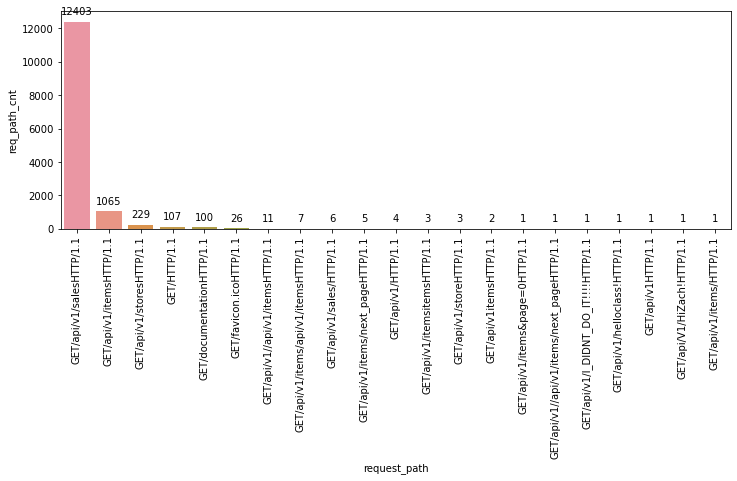

In [18]:
# plot the req_method_count for each request_method

plt.figure(figsize=(12, 4))
splot = sns.barplot(data=rm_df, x = 'request_path', y = 'req_path_cnt', ci = None)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', xytext = (0, 10), 
                   textcoords = 'offset points'
                   )
    plt.xticks(rotation='vertical')

Detecting anomalies by establishing a baseline and evaluate as new data arrives
- Establish Baseline:

In [19]:
df.head(1)

,ip,request_path,status_code,user_agent,size_mb
timestamp,,,,,
16/Apr/2019 19:34:42,97.105.19.58,GET/api/v1/salesHTTP/1.1,200,python-requests/2.21.0,0.488753


In [20]:
df.tail(1)

,ip,request_path,status_code,user_agent,size_mb
timestamp,,,,,
21/Apr/2019 10:02:41,95.31.18.119,GET/api/v1/items/HTTP/1.1,200,python-requests/2.21.0,1.099591


In [21]:
# we want the original df
sample_df = df.loc['16/Apr/2019 19:34:42':'21/Apr/2019 10:02:41']

In [22]:
sample_df.shape

(13978, 5)

In [23]:
sample_df.size /df.size

1.0

In [24]:
sample_df.request_path.value_counts(dropna=False)

GET/api/v1/salesHTTP/1.1                      12403
GET/api/v1/itemsHTTP/1.1                       1065
GET/api/v1/storesHTTP/1.1                       229
GET/HTTP/1.1                                    107
GET/documentationHTTP/1.1                       100
GET/favicon.icoHTTP/1.1                          26
GET/api/v1//api/v1/itemsHTTP/1.1                 11
GET/api/v1/items/api/v1/itemsHTTP/1.1             7
GET/api/v1/sales/HTTP/1.1                         6
GET/api/v1/items/next_pageHTTP/1.1                5
GET/api/v1/HTTP/1.1                               4
GET/api/v1/itemsitemsHTTP/1.1                     3
GET/api/v1/storeHTTP/1.1                          3
GET/api/v1itemsHTTP/1.1                           2
GET/api/v1/items&page=0HTTP/1.1                   1
GET/api/v1//api/v1/items/next_pageHTTP/1.1        1
GET/api/v1/I_DIDNT_DO_IT!!!!HTTP/1.1              1
GET/api/v1/helloclass!HTTP/1.1                    1
GET/api/v1HTTP/1.1                                1
GET/api/V1/H

In [25]:
sample_df.request_path.count()

13978

In [26]:
# Compute probabilities based on train sample:
rm_df = pd.DataFrame(sample_df.request_path.value_counts(dropna=False) / sample_df.request_path.count()).reset_index().\
    rename(columns = {'index': 'request_path', 'request_path': 'rm_proba'})

In [27]:
rm_df.head()

,request_path,rm_proba
0,GET/api/v1/salesHTTP/1.1,0.887323
1,GET/api/v1/itemsHTTP/1.1,0.076191
2,GET/api/v1/storesHTTP/1.1,0.016383
3,GET/HTTP/1.1,0.007655
4,GET/documentationHTTP/1.1,0.007154


In [28]:
# Where the request_method  is new, i.e. not seen in the sample 
#  dataset, fill the probability with a value of 0.
df = df.reset_index().merge(rm_df, on=['request_path'], how='left').fillna(value=0).set_index('timestamp')

In [29]:
df[df.rm_proba > 0]

,ip,request_path,status_code,user_agent,size_mb,rm_proba
timestamp,,,,,,
16/Apr/2019 19:34:42,97.105.19.58,GET/api/v1/salesHTTP/1.1,200,python-requests/2.21.0,0.488753,0.887323
16/Apr/2019 19:34:42,97.105.19.58,GET/api/v1/itemsHTTP/1.1,200,python-requests/2.21.0,0.003396,0.076191
16/Apr/2019 19:34:44,97.105.19.58,GET/api/v1/salesHTTP/1.1,200,python-requests/2.21.0,0.486472,0.887323
16/Apr/2019 19:34:46,97.105.19.58,GET/api/v1/salesHTTP/1.1,200,python-requests/2.21.0,0.486377,0.887323
16/Apr/2019 19:34:48,97.105.19.58,GET/api/v1/salesHTTP/1.1,200,python-requests/2.21.0,0.488246,0.887323
...,...,...,...,...,...,...
17/Apr/2019 12:55:14,97.105.19.58,GET/api/v1/salesHTTP/1.1,200,python-requests/2.21.0,0.486532,0.887323
17/Apr/2019 19:36:41,95.31.16.121,GET/api/v1/sales/HTTP/1.1,301,python-requests/2.21.0,0.000958,0.000429
18/Apr/2019 19:42:41,97.105.15.120,GET/api/v1/sales/HTTP/1.1,301,python-requests/2.21.0,0.002441,0.000429


In [30]:
df.head(3)

,ip,request_path,status_code,user_agent,size_mb,rm_proba
timestamp,,,,,,
16/Apr/2019 19:34:42,97.105.19.58,GET/api/v1/salesHTTP/1.1,200,python-requests/2.21.0,0.488753,0.887323
16/Apr/2019 19:34:42,97.105.19.58,GET/api/v1/itemsHTTP/1.1,200,python-requests/2.21.0,0.003396,0.076191
16/Apr/2019 19:34:44,97.105.19.58,GET/api/v1/salesHTTP/1.1,200,python-requests/2.21.0,0.486472,0.887323


Conditional Probabilities: Probabilities using 2 discrete variables
- Probability of Status given request_method

In [31]:
sample_df.head()

,ip,request_path,status_code,user_agent,size_mb
timestamp,,,,,
16/Apr/2019 19:34:42,97.105.19.58,GET/api/v1/salesHTTP/1.1,200,python-requests/2.21.0,0.488753
16/Apr/2019 19:34:42,97.105.19.58,GET/api/v1/itemsHTTP/1.1,200,python-requests/2.21.0,0.003396
16/Apr/2019 19:34:44,97.105.19.58,GET/api/v1/salesHTTP/1.1,200,python-requests/2.21.0,0.486472
16/Apr/2019 19:34:46,97.105.19.58,GET/api/v1/salesHTTP/1.1,200,python-requests/2.21.0,0.486377
16/Apr/2019 19:34:48,97.105.19.58,GET/api/v1/salesHTTP/1.1,200,python-requests/2.21.0,0.488246


#Conditional probability. Probability of A given B

**prob(A|B) = prob(A & B) / prob(B)**

In [32]:
#size counts the number of nans too
sample_df.groupby('request_path').size()

request_path
GET/HTTP/1.1                                    107
GET/api/V1/HiZach!HTTP/1.1                        1
GET/api/v1//api/v1/items/next_pageHTTP/1.1        1
GET/api/v1//api/v1/itemsHTTP/1.1                 11
GET/api/v1/HTTP/1.1                               4
GET/api/v1/I_DIDNT_DO_IT!!!!HTTP/1.1              1
GET/api/v1/helloclass!HTTP/1.1                    1
GET/api/v1/items&page=0HTTP/1.1                   1
GET/api/v1/items/HTTP/1.1                         1
GET/api/v1/items/api/v1/itemsHTTP/1.1             7
GET/api/v1/items/next_pageHTTP/1.1                5
GET/api/v1/itemsHTTP/1.1                       1065
GET/api/v1/itemsitemsHTTP/1.1                     3
GET/api/v1/sales/HTTP/1.1                         6
GET/api/v1/salesHTTP/1.1                      12403
GET/api/v1/storeHTTP/1.1                          3
GET/api/v1/storesHTTP/1.1                       229
GET/api/v1HTTP/1.1                                1
GET/api/v1itemsHTTP/1.1                           2

In [33]:
#calculate prob(a&b)
sample_df.groupby(['request_path', 'status_code']).size()

request_path                                status_code
GET/HTTP/1.1                                200              107
GET/api/V1/HiZach!HTTP/1.1                  200                1
GET/api/v1//api/v1/items/next_pageHTTP/1.1  200                1
GET/api/v1//api/v1/itemsHTTP/1.1            200               11
GET/api/v1/HTTP/1.1                         200                4
GET/api/v1/I_DIDNT_DO_IT!!!!HTTP/1.1        200                1
GET/api/v1/helloclass!HTTP/1.1              200                1
GET/api/v1/items&page=0HTTP/1.1             200                1
GET/api/v1/items/HTTP/1.1                   200                1
GET/api/v1/items/api/v1/itemsHTTP/1.1       200                7
GET/api/v1/items/next_pageHTTP/1.1          200                5
GET/api/v1/itemsHTTP/1.1                    200             1061
                                            499                4
GET/api/v1/itemsitemsHTTP/1.1               200                3
GET/api/v1/sales/HTTP/1.1         

In [34]:
#using .div is the same as using /
#  prob(A|B) = prob(A & B) / prob(B)
Pab = sample_df.groupby(['request_path', 'status_code']).size().div(len(sample_df))

In [35]:
sample_df.groupby(['request_path', 'status_code']).size()/(len(sample_df))

request_path                                status_code
GET/HTTP/1.1                                200            0.007655
GET/api/V1/HiZach!HTTP/1.1                  200            0.000072
GET/api/v1//api/v1/items/next_pageHTTP/1.1  200            0.000072
GET/api/v1//api/v1/itemsHTTP/1.1            200            0.000787
GET/api/v1/HTTP/1.1                         200            0.000286
GET/api/v1/I_DIDNT_DO_IT!!!!HTTP/1.1        200            0.000072
GET/api/v1/helloclass!HTTP/1.1              200            0.000072
GET/api/v1/items&page=0HTTP/1.1             200            0.000072
GET/api/v1/items/HTTP/1.1                   200            0.000072
GET/api/v1/items/api/v1/itemsHTTP/1.1       200            0.000501
GET/api/v1/items/next_pageHTTP/1.1          200            0.000358
GET/api/v1/itemsHTTP/1.1                    200            0.075905
                                            499            0.000286
GET/api/v1/itemsitemsHTTP/1.1               200            0

In [36]:
#calculate Pb
Pb = sample_df.groupby('request_path').size().div(len(sample_df))

In [37]:
Pb

request_path
GET/HTTP/1.1                                  0.007655
GET/api/V1/HiZach!HTTP/1.1                    0.000072
GET/api/v1//api/v1/items/next_pageHTTP/1.1    0.000072
GET/api/v1//api/v1/itemsHTTP/1.1              0.000787
GET/api/v1/HTTP/1.1                           0.000286
GET/api/v1/I_DIDNT_DO_IT!!!!HTTP/1.1          0.000072
GET/api/v1/helloclass!HTTP/1.1                0.000072
GET/api/v1/items&page=0HTTP/1.1               0.000072
GET/api/v1/items/HTTP/1.1                     0.000072
GET/api/v1/items/api/v1/itemsHTTP/1.1         0.000501
GET/api/v1/items/next_pageHTTP/1.1            0.000358
GET/api/v1/itemsHTTP/1.1                      0.076191
GET/api/v1/itemsitemsHTTP/1.1                 0.000215
GET/api/v1/sales/HTTP/1.1                     0.000429
GET/api/v1/salesHTTP/1.1                      0.887323
GET/api/v1/storeHTTP/1.1                      0.000215
GET/api/v1/storesHTTP/1.1                     0.016383
GET/api/v1HTTP/1.1                            0.0000

In [38]:
#prob(A|B) = prob(A & B) / prob(B)
Pab.div(Pb, axis = 0, level = 'request_path' )

request_path                                status_code
GET/HTTP/1.1                                200            1.000000
GET/api/V1/HiZach!HTTP/1.1                  200            1.000000
GET/api/v1//api/v1/items/next_pageHTTP/1.1  200            1.000000
GET/api/v1//api/v1/itemsHTTP/1.1            200            1.000000
GET/api/v1/HTTP/1.1                         200            1.000000
GET/api/v1/I_DIDNT_DO_IT!!!!HTTP/1.1        200            1.000000
GET/api/v1/helloclass!HTTP/1.1              200            1.000000
GET/api/v1/items&page=0HTTP/1.1             200            1.000000
GET/api/v1/items/HTTP/1.1                   200            1.000000
GET/api/v1/items/api/v1/itemsHTTP/1.1       200            1.000000
GET/api/v1/items/next_pageHTTP/1.1          200            1.000000
GET/api/v1/itemsHTTP/1.1                    200            0.996244
                                            499            0.003756
GET/api/v1/itemsitemsHTTP/1.1               200            1

In [39]:
#other way
Pab/Pb

request_path                                status_code
GET/HTTP/1.1                                200            1.000000
GET/api/V1/HiZach!HTTP/1.1                  200            1.000000
GET/api/v1//api/v1/items/next_pageHTTP/1.1  200            1.000000
GET/api/v1//api/v1/itemsHTTP/1.1            200            1.000000
GET/api/v1/HTTP/1.1                         200            1.000000
GET/api/v1/I_DIDNT_DO_IT!!!!HTTP/1.1        200            1.000000
GET/api/v1/helloclass!HTTP/1.1              200            1.000000
GET/api/v1/items&page=0HTTP/1.1             200            1.000000
GET/api/v1/items/HTTP/1.1                   200            1.000000
GET/api/v1/items/api/v1/itemsHTTP/1.1       200            1.000000
GET/api/v1/items/next_pageHTTP/1.1          200            1.000000
GET/api/v1/itemsHTTP/1.1                    200            0.996244
                                            499            0.003756
GET/api/v1/itemsitemsHTTP/1.1               200            1

In [40]:
# calculate prob for each request_method in sample_df

ip_probs = sample_df.groupby('request_path').size().div(len(sample_df))

ip_probs

request_path
GET/HTTP/1.1                                  0.007655
GET/api/V1/HiZach!HTTP/1.1                    0.000072
GET/api/v1//api/v1/items/next_pageHTTP/1.1    0.000072
GET/api/v1//api/v1/itemsHTTP/1.1              0.000787
GET/api/v1/HTTP/1.1                           0.000286
GET/api/v1/I_DIDNT_DO_IT!!!!HTTP/1.1          0.000072
GET/api/v1/helloclass!HTTP/1.1                0.000072
GET/api/v1/items&page=0HTTP/1.1               0.000072
GET/api/v1/items/HTTP/1.1                     0.000072
GET/api/v1/items/api/v1/itemsHTTP/1.1         0.000501
GET/api/v1/items/next_pageHTTP/1.1            0.000358
GET/api/v1/itemsHTTP/1.1                      0.076191
GET/api/v1/itemsitemsHTTP/1.1                 0.000215
GET/api/v1/sales/HTTP/1.1                     0.000429
GET/api/v1/salesHTTP/1.1                      0.887323
GET/api/v1/storeHTTP/1.1                      0.000215
GET/api/v1/storesHTTP/1.1                     0.016383
GET/api/v1HTTP/1.1                            0.0000

In [41]:
# Conditional probability. Given a request_method, whbat is prob of a particular status
sample_df.groupby(['request_path', 'status_code']).\
                               size().div(len(sample_df))

request_path                                status_code
GET/HTTP/1.1                                200            0.007655
GET/api/V1/HiZach!HTTP/1.1                  200            0.000072
GET/api/v1//api/v1/items/next_pageHTTP/1.1  200            0.000072
GET/api/v1//api/v1/itemsHTTP/1.1            200            0.000787
GET/api/v1/HTTP/1.1                         200            0.000286
GET/api/v1/I_DIDNT_DO_IT!!!!HTTP/1.1        200            0.000072
GET/api/v1/helloclass!HTTP/1.1              200            0.000072
GET/api/v1/items&page=0HTTP/1.1             200            0.000072
GET/api/v1/items/HTTP/1.1                   200            0.000072
GET/api/v1/items/api/v1/itemsHTTP/1.1       200            0.000501
GET/api/v1/items/next_pageHTTP/1.1          200            0.000358
GET/api/v1/itemsHTTP/1.1                    200            0.075905
                                            499            0.000286
GET/api/v1/itemsitemsHTTP/1.1               200            0

In [42]:
status_given_rm = pd.DataFrame(sample_df.groupby(['request_path', 'status_code']).\
                               size().div(len(sample_df)).\
                               div(ip_probs, 
                                   axis=0, 
                                   level='request_path').\
                               reset_index().\
                               rename(columns={0: 'proba_status_given_rm'})
                              )

In [43]:
status_given_rm

,request_path,status_code,proba_status_given_rm
0,GET/HTTP/1.1,200,1.000000
1,GET/api/V1/HiZach!HTTP/1.1,200,1.000000
2,GET/api/v1//api/v1/items/next_pageHTTP/1.1,200,1.000000
3,GET/api/v1//api/v1/itemsHTTP/1.1,200,1.000000
4,GET/api/v1/HTTP/1.1,200,1.000000
5,GET/api/v1/I_DIDNT_DO_IT!!!!HTTP/1.1,200,1.000000
6,GET/api/v1/helloclass!HTTP/1.1,200,1.000000
7,GET/api/v1/items&page=0HTTP/1.1,200,1.000000
8,GET/api/v1/items/HTTP/1.1,200,1.000000
9,GET/api/v1/items/api/v1/itemsHTTP/1.1,200,1.000000


In [44]:
# calculate count for each combination of request_ and status
rm_status_count = pd.DataFrame(sample_df.groupby(['request_path', 'status_code'])['ip'].count().reset_index().\
            rename(columns={'ip':'rm_status_count'}))

In [45]:
rm_status_count

,request_path,status_code,rm_status_count
0,GET/HTTP/1.1,200,107
1,GET/api/V1/HiZach!HTTP/1.1,200,1
2,GET/api/v1//api/v1/items/next_pageHTTP/1.1,200,1
3,GET/api/v1//api/v1/itemsHTTP/1.1,200,11
4,GET/api/v1/HTTP/1.1,200,4
5,GET/api/v1/I_DIDNT_DO_IT!!!!HTTP/1.1,200,1
6,GET/api/v1/helloclass!HTTP/1.1,200,1
7,GET/api/v1/items&page=0HTTP/1.1,200,1
8,GET/api/v1/items/HTTP/1.1,200,1
9,GET/api/v1/items/api/v1/itemsHTTP/1.1,200,7


In [46]:
# merge ip_status_count with status_given_ip dataframe

rm_status =status_given_rm.merge(rm_status_count)

In [47]:
rm_status.head(3)

,request_path,status_code,proba_status_given_rm,rm_status_count
0,GET/HTTP/1.1,200,1.0,107
1,GET/api/V1/HiZach!HTTP/1.1,200,1.0,1
2,GET/api/v1//api/v1/items/next_pageHTTP/1.1,200,1.0,1


In [48]:
df = df.reset_index().merge(rm_status, on=['request_path', 'status_code'], how='left').fillna(value=0).set_index('timestamp')

In [49]:
df.head()

,ip,request_path,status_code,user_agent,size_mb,rm_proba,proba_status_given_rm,rm_status_count
timestamp,,,,,,,,
16/Apr/2019 19:34:42,97.105.19.58,GET/api/v1/salesHTTP/1.1,200,python-requests/2.21.0,0.488753,0.887323,0.999032,12391
16/Apr/2019 19:34:42,97.105.19.58,GET/api/v1/itemsHTTP/1.1,200,python-requests/2.21.0,0.003396,0.076191,0.996244,1061
16/Apr/2019 19:34:44,97.105.19.58,GET/api/v1/salesHTTP/1.1,200,python-requests/2.21.0,0.486472,0.887323,0.999032,12391
16/Apr/2019 19:34:46,97.105.19.58,GET/api/v1/salesHTTP/1.1,200,python-requests/2.21.0,0.486377,0.887323,0.999032,12391
16/Apr/2019 19:34:48,97.105.19.58,GET/api/v1/salesHTTP/1.1,200,python-requests/2.21.0,0.488246,0.887323,0.999032,12391


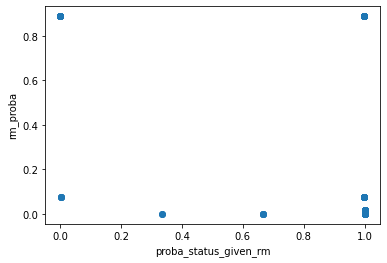

In [50]:
# plot the probabilities

plt.scatter(df.proba_status_given_rm, df.rm_proba)
plt.xlabel('proba_status_given_rm')
plt.ylabel('rm_proba');

In [51]:
df[(df['proba_status_given_rm'] < 0.2) & (df['rm_proba'] < 0.2)]

,ip,request_path,status_code,user_agent,size_mb,rm_proba,proba_status_given_rm,rm_status_count
timestamp,,,,,,,,
16/Apr/2019 20:38:13,97.105.19.58,GET/api/v1/itemsHTTP/1.1,499,python-requests/2.21.0,0.0,0.076191,0.003756,4
16/Apr/2019 20:38:55,97.105.19.58,GET/api/v1/itemsHTTP/1.1,499,python-requests/2.21.0,0.0,0.076191,0.003756,4
16/Apr/2019 20:39:00,97.105.19.58,GET/api/v1/itemsHTTP/1.1,499,python-requests/2.21.0,0.0,0.076191,0.003756,4
16/Apr/2019 20:45:17,97.105.19.58,GET/api/v1/itemsHTTP/1.1,499,python-requests/2.21.0,0.0,0.076191,0.003756,4


#https://www.exai.com/blog/http-status-codes-cheat-sheet
200 = OK: Successful request.
301 = Moved Permanently: The server tells the client that the resource they look for has been moved permanently to another URL. All users and bots will be redirected to the new URL. It's a very important status code for SEO.
499 CLIENT CLOSED REQUEST

In [53]:
df [(df.ip == '97.105.19.58') & (df.request_path == 'GET/api/v1/itemsHTTP/1.1') ].groupby('status_code').count()

,ip,request_path,user_agent,size_mb,rm_proba,proba_status_given_rm,rm_status_count
status_code,,,,,,,


In [54]:
df[df.request_path=='GET /api/v1/I_DIDNT_DO_IT!!!!HTTP/1.1']

AttributeError: 'DataFrame' object has no attribute 'request_method'